This notebook was made by Bruno Rodrigues Silva, contact me anyway you prefer
- https://github.com/brunorosilva
- https://www.linkedin.com/in/brunorosilva
- rodriguessilvabruno@oulook.com

# XNature V2 Classifier


The XNature V2 dataset contains x-ray images of 8 diffent classes:
<ol>
<li>Fruits
<li>Guns
<li>Keys
<li>Knifes
<li>Razors
<li>Salmons
<li>Shurikens
<li>Wood
</ol>

The objectives of this notebook are explore the dataset, preprocess the image data and to create a image classifier using Deep Learning.<br><br>
For this particular task it'll be used the Keras API, since it's faster and simpler than using TensorFlow to test lots of hypotesis using Deep Learning.

## Data Exploration

#### Getting the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten
from keras.models import Sequential
from os import listdir
from os.path import isfile, join
import numpy as np
mypath = "C:\\Users\\rodri\\Desktop\\xnaturev2\\XNature"
pastas = listdir(mypath)
pastas.remove('.ipynb_checkpoints')
pastas.remove('Untitled1.ipynb')
pastas.remove('XNature_Classification.ipynb')
pastas.remove('XNature')

Using TensorFlow backend.


In [2]:
from PIL import Image
x = []
y = []
siz = (200,200)

for pasta in pastas:
    path_pastas = mypath + '\\' + pasta
    files = listdir(path_pastas)
    for file in files:
        img = Image.open(path_pastas + '\\'+ file)
        img_rsz = img.resize(siz)
        x.append(np.asarray(img_rsz))
        y.append(pasta)

        

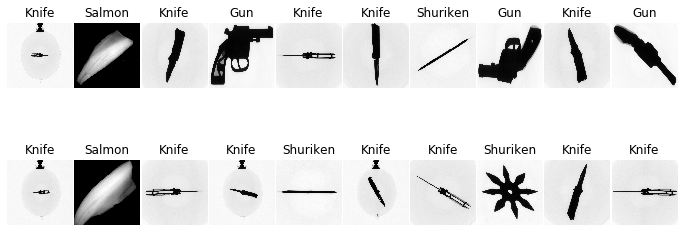

In [3]:
# Let's take a look at these images

x = np.array(x)
y = np.array(y)
rand = np.random.randint(0, x.shape[0], 20)
sample_imgs = x[rand]
sample_labels = y[rand]

# code to view the images

num_rows, num_cols = 2, 10
f, ax = plt.subplots(num_rows, num_cols, figsize=(12,5),
                     gridspec_kw={'wspace':0.03, 'hspace':0.01}, 
                     squeeze=True)

for r in range(num_rows):
    for c in range(num_cols):
        image_index = r * num_cols + c
        ax[r,c].axis("off")
        ax[r,c].imshow(sample_imgs[image_index], cmap='gray')
        ax[r,c].set_title(sample_labels[image_index])
plt.show()
plt.close()

In [4]:
print('So far we\'ve seen how some of these images look like in grayscale and we are able to address each of the '+str(x.shape[0])+' images\ninto '+str(len(np.unique(y)))+' unique categories, just as it was described earlier')

So far we've seen how some of these images look like in grayscale and we are able to address each of the 2984 images
into 8 unique categories, just as it was described earlier


## Separating the data into train, validation and test

For this particular part it'll be used the sklearn's train test split, because it's a very simple way to split the data

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# defining test size and fixed random state for reproducibility purposes
test_size = .20
random_state = 42

# transforming y labels into numbers
LE = LabelEncoder()
y_lab = LE.fit_transform(y)


x_train, x_test, y_train, y_test = train_test_split(x, y_lab, test_size = test_size, random_state = random_state)

In [6]:
print("Summary:")
print("Number of train imgs:", x_train.shape[0])
print("Number of test imgs:", x_test.shape[0])
print("Number of train labels:", len(np.unique(y_train)))
print("Number of test imgs:", len(np.unique(y_test)))

Summary:
Number of train imgs: 2387
Number of test imgs: 597
Number of train labels: 8
Number of test imgs: 8


Let's take a look at the distribuition of labels in our dataset

In [7]:
unique_elements_train, counts_elements_train = np.unique(y_train, return_counts=True)
unique_elements_test, counts_elements_test = np.unique(y_test, return_counts=True)

print('In the training dataset: ')

for i in range(len(unique_elements_train)):
    print('Class {0} {1:.2f}%'.
          format(unique_elements_train[i], counts_elements_train[i]/len(y_train)*100))

print('\n\nIn the testing dataset: ')
for i in range(len(unique_elements_test)):

    print('Class {0} {1:.2f}%'.
          format(unique_elements_test[i], counts_elements_test[i]/len(y_test)*100))
    

In the training dataset: 
Class 0 2.01%
Class 1 6.20%
Class 2 1.26%
Class 3 57.90%
Class 4 3.52%
Class 5 5.53%
Class 6 18.31%
Class 7 5.28%


In the testing dataset: 
Class 0 2.01%
Class 1 8.71%
Class 2 1.17%
Class 3 57.96%
Class 4 2.68%
Class 5 6.20%
Class 6 15.91%
Class 7 5.36%


Asserting the data above, it can be issued that both the train and the test arrays have a close proximity in distribuition.

## Data Processing

In [8]:
from keras.utils import to_categorical
img_height = sample_imgs[0].shape[0]
img_width = sample_imgs[0].shape[1]
num_channels = 1

train_data = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], num_channels))
test_data = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2], num_channels))

In [9]:
train_data = train_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

num_classes = 8
train_labels_cat = to_categorical(y_train,num_classes)
test_labels_cat = to_categorical(y_test,num_classes)

In [10]:
for _ in range(5): 
    indexes = np.random.permutation(len(train_data))

train_data = train_data[indexes]
train_labels_cat = train_labels_cat[indexes]

# now set-aside 10% of the train_data/labels as the
# cross-validation sets
val_perc = 0.10
val_count = int(val_perc * len(train_data))

# first pick validation set from train_data/labels
val_data = train_data[:val_count,:]
val_labels_cat = train_labels_cat[:val_count,:]
train_data2 = train_data[val_count:,:]
train_labels_cat2 = train_labels_cat[val_count:,:]

### Creating the Neural Network

Schematics of the Neural Network (made with NN SVG)<br><br>
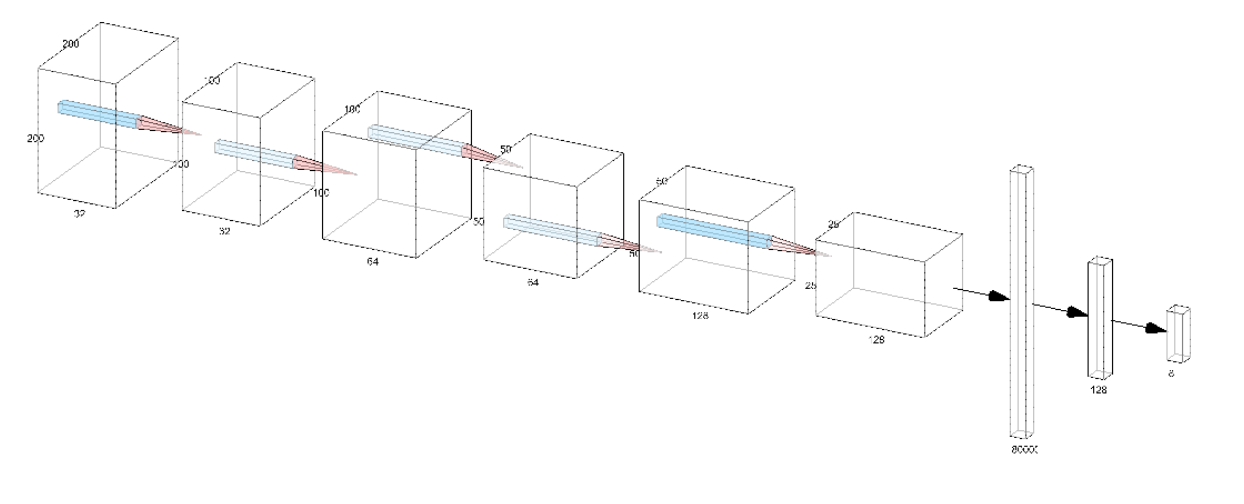<br><br>

It's composed by three sequences of Convolution -> Max-Pooling layers followed by a flatten layer and then by a 128 node fully conected layer and a 8 node layer fully conected output.

The activation function of all but the last layer is the ReLU fuction, the activation function used in the last layer is the softmax fuction.

In [11]:
model = Sequential()
model.add(Conv2D(32, (2,2), padding = 'same', activation = 'relu',  input_shape=(img_height, img_width, num_channels)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (2,2), padding = 'same', activation = 'relu',  input_shape=(img_height, img_width, num_channels)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (2,2), padding = 'same', activation = 'relu',  input_shape=(img_height, img_width, num_channels)))
model.add(MaxPooling2D(2,2))
model.add(Flatten())

model.add(Dense(128, activation = 'relu'))

model.add(Dense(8, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

print(model.summary())







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 128)       32896     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80000)      

In [12]:
results = model.fit(train_data2, train_labels_cat2, 
                    epochs=15, batch_size=64,
                    validation_data=(val_data, val_labels_cat))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 2149 samples, validate on 238 samples
Epoch 1/15
2149/2149 [==============================] - 57s 26ms/step - loss: 0.5616 - acc: 0.8120 - val_loss: 0.0777 - val_acc: 0.9748
Epoch 2/15
2149/2149 [==============================] - 53s 25ms/step - loss: 0.0444 - acc: 0.9846 - val_loss: 0.0145 - val_acc: 1.0000
Epoch 3/15
2149/2149 [==============================] - 57s 27ms/step - loss: 0.0100 - acc: 0.9972 - val_loss: 0.0046 - val_acc: 1.0000
Epoch 4/15
2149/2149 [==============================] - 58s 27ms/step - loss: 0.0042 - acc: 0.9986 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 5/15
2149/2149 [==============================] - 61s 28ms/step - loss: 0.0025 - acc: 0.9995 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 6/15
2149/2149 [==============================] - 63s 29ms/step - loss: 7.0570e-04 - acc: 1.0000 - val_loss: 9.6757e-04 - val_acc: 1.0000
Epoch 7/15
2149/2149 [============

In [13]:
# This piece of code is from another person, I found this over 1 year ago in a tutorial but I since lost the original link,
# I'm only using because it saves lots of time.
def show_plots(history, plot_title=None, fig_size=None):
    """ Useful function to view plot of loss values & accuracies across the various epochs
        Works with the history object returned by the train_model(...) call """
    assert type(history) is dict

    # NOTE: the history object should always have loss & acc (for training data), but MAY have
    # val_loss & val_acc for validation data
    loss_vals = history['loss']
    val_loss_vals = history['val_loss'] if 'val_loss' in history.keys() else None
    epochs = range(1, len(history['acc']) + 1)

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=((16, 4) if fig_size is None else fig_size))

    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy', marker='o', linestyle=' ', label='Training Loss')
    if val_loss_vals is not None:
        ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
        ax[0].set_title('Training & Validation Loss')
        ax[0].legend(loc='best')
    else:
        ax[0].set_title('Training Loss')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid(True)

    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc'] if 'val_acc' in history.keys() else None

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    if val_acc_vals is not None:
        ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
        ax[1].set_title('Training & Validation Accuracy')
        ax[1].legend(loc='best')
    else:
        ax[1].set_title('Training Accuracy')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].grid(True)

    if plot_title is not None:
        plt.suptitle(plot_title)

    plt.show()
    plt.close()

    # delete locals from heap before exiting (to save some memory!)
    del loss_vals, epochs, acc_vals
    if val_loss_vals is not None:
        del val_loss_vals
    if val_acc_vals is not None:
        del val_acc_vals
        

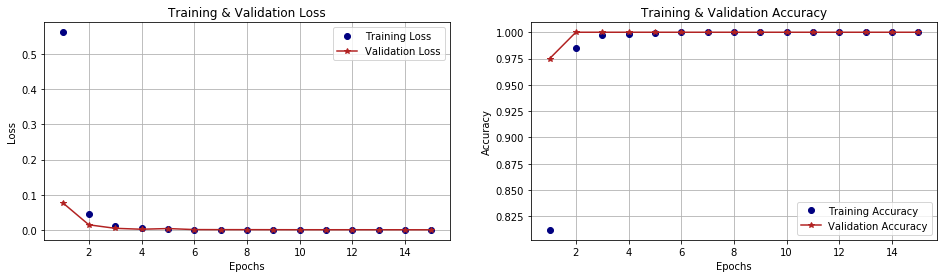

In [14]:
show_plots(results.history)

### Now into the test set

In [15]:
y_pred = model.predict_classes(test_data)
actual = []
cnt = 0
for i in range(len(test_labels_cat)):
    for cat in test_labels_cat[i]:
        if cat == 1:
            actual.append(np.where(test_labels_cat[i]==cat)[0][0])
            
for i in range(len(y_pred)):
    if(y_pred[i] != actual[i]):
        cnt += 1

score = model.evaluate(test_data, test_labels_cat, verbose=1)
print('Test loss     :', score[0])
print('Test accuracy : {:.2f}%'.format(score[1]*100))
print('Test set size :', len(test_data))
print('Right guesses :', len(test_data)-cnt)

597/597 [==============================] - 5s 9ms/step
Test loss     : 0.0266572779073369
Test accuracy : 99.83%
Test set size : 597
Right guesses : 596


## Discussion

#### About the challenge

I think the challenge was very funny and welcoming, if this is the everyday life of a image recognition data scientist then I'd really like to be a part of that.
<br><br>
I had never seen a challenge like this one and it put somewhat everyday objects in a diferent perspective. At first I really thougth that by x-raying the objects the quality of the image would be lost, but the majority of the images were in a better quality and resolution than what I was expecting.
<br><br>
The challenge took me close to 3 days (about 4h each day), mainly because I got stuck with the dimensionatily of the images being diferent and choosing the best size for the images. 
<br><br><br>
#### About the methods I used

From the get-go my roadmap was using a CNN with convolutional and max-pooling layers because this means convolutioning in a big image and then doing it again on a smaller and more significative piece of the same image. <br><br>
Breaking down to all the decision I had to make:<br>
###### The programming language choice
I'm using Python as it's the programming language I feel the most confortable and has a fairly simple sintax.

###### Using Keras
I decided with doing the entire model using Keras, as it is superficial enough for fast testing diferent NNs structures and still having very good model performance.
###### Train, Validation and Test spliting 
I split the entire dataset into train, validation and test sets, as it is the most standart procedure for these kind of task. I used 10% for validation and 20% for testing and the categories were pretty evenly distribuited into these 3 sets.
###### The actual CNN model

I decided to go straight into 3 Conv2D + MaxPool layers mainly because of the size of the images and aiming to reduce dimensionality because of the reduced stride (2,2) used in all layers.<br>Researching about CNN size I stumbled upon <a href = 'https://arxiv.org/pdf/1512.00567.pdf'> this paper</a>, made by Google Research which focused into the best architecture for CNNs and it helped me a lot when I was thinking about how large I was going to make this NN.<br><br><br>

#### About the Results
I'm  very happy with how accurate this model turned out, achieving 99.83% of acc. But I'm not very confortable with the performance of the model, since I feel like a simpler version of the NN would make good enough results faster. One point that got me thiking is how fast this model actually converges into a high accuracy on the validation set (graph above), taking only about 5 epochs.
<br><br><br>

#### Next Steps
There's always room for improvement, with that said I'd really like to try this solution in a more efficient manner mainly by tunning the hyperparameters.<br><br> The main thing I'd like to do is to test this model in an airport x-ray line looking for guns, knifes and razors inside people's luggage (this is why I'd like it to predict faster). <br><br>Other really nice tests would include testing the results with diferent kinds of x-ray machines, using diferent filters in the images, testing using a dataset with more categories, trying to predict how much each object weights and its size using deep learning depth estimation or even predicting which material the object is made of by using weight data and depth estimation.<br><br>
The sky is the limit with this kind of ideas.

